In [1]:
import sys 
sys.path.append("./tabnet/tf_tabnet/")

import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import load_model, save_model
from keras import backend as K

from tensorflow_addons.optimizers import AdamW

from model.arcface_loss import ArcFace
import tabnet_model

from train import encode_y, scale_X, quantile_X, grouped_train_test_split #, make_X_y
from eval import recall_at_k

In [2]:
def seed_everything(seed=24):
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(24)

In [3]:
df = pd.read_parquet("../../../../data/clean/clean_sample.parquet")
df.shape

(197305, 991)

In [4]:
def make_X_y(df):
    """
    Split into gene expression values (X) and perturbagen labels (y)
    """
    df = df.drop(['pert_dose', 
    'pert_dose_unit', 
    'pert_id', 
    'pert_mfc_id',
    'pert_time', 
    'pert_time_unit', 
    'pert_type', 
    'rna_plate', 
    'rna_well',
    #'cell_id',
    'det_plate',
    'det_well'
    ], axis=1)

    X = df.loc[:, df.columns != 'pert_iname']
    y = df['pert_iname']
    return (X, y)

In [5]:
X, y = make_X_y(df)
cat_cols = list(X.select_dtypes(include=["object"]).columns)
num_cols = X.columns.difference(cat_cols)

In [6]:
X_train, X_test, y_train, y_test = grouped_train_test_split(X, y, y, test_size=0.2)
X_train_num_scale, X_test_num_scale = scale_X(X_train[num_cols], X_test[num_cols]) #df.values[:] = StandardScaler().fit_transform(df)
#X_train_scale, X_test_scale = quantile_X(X_train, X_test)

X_train_scale = pd.concat([pd.DataFrame(X_train_num_scale), X_train[cat_cols].reset_index(drop=True)], axis=1)
X_test_scale = pd.concat([pd.DataFrame(X_test_num_scale), X_test[cat_cols].reset_index(drop=True)], axis=1)

In [7]:
num_classes = len(np.unique(y_train))
y_train_encode = encode_y(y_train)

In [8]:
BATCH_SIZE = 1024

train_dataset = Dataset.from_tensor_slices((dict(X_train), y_train_encode))
label_dataset = Dataset.from_tensor_slices(y_train_encode)
dataset = Dataset.zip((train_dataset, label_dataset)).shuffle(100).batch(BATCH_SIZE).prefetch(2)

2022-07-06 17:14:47.966961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-06 17:14:48.499252: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10794 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


In [9]:
def create_keras_input_layer(feature_names, cat_str_feature_names):
    model_inputs = list()
    
    for name in feature_names:
        if name in cat_str_feature_names:
            dtype = tf.string
        else:
            dtype = tf.float32
        
        shape = (1,) if dtype==tf.float32 else ()
        model_inputs.append(tf.keras.Input(shape=shape, name=name, dtype=dtype))
    
    return model_inputs

In [10]:
def encode_categorical_feature(keras_input, feature_name, dataset, 
                               embed_dim, is_string):
    feature_ds = dataset.map(lambda x, _: x[feature_name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    lookup_fn = tf.keras.layers.StringLookup if is_string else tf.keras.layers.IntegerLookup
    lookup = lookup_fn(output_mode="int")
    lookup.adapt(feature_ds)
    encoded_feature = lookup(keras_input)
    embedded_feature = tf.keras.layers.Embedding(
        input_dim=lookup.vocabulary_size(), 
        output_dim=embed_dim, 
        name=f"{feature_name}_embedding"
    )(encoded_feature)

    return embedded_feature


def encode_features(keras_inputs, feature_names, 
                    cat_str_feature_names, cat_embed_dims, 
                    dataset):
    encoded_features = list()

    for keras_input, feature_name in zip(keras_inputs, feature_names):
        if feature_name in cat_str_feature_names:
            # add embedding layer for all categorical features
            embed_dim = cat_embed_dims[feature_name] if feature_name in cat_embed_dims.keys() else 1
            encoded_features.append(
                encode_categorical_feature(keras_input, feature_name, 
                                           dataset, 
                                           embed_dim, 
                                           feature_name in cat_str_feature_names)
            )
        else: 
            # no encoding for numerical features
            encoded_features.append(keras_input)
    
    return encoded_features

In [11]:
tabnet_params = {
        "decision_dim": 64, 
        "attention_dim": 128, 
        "n_steps": 1, 
        "n_shared_glus": 1, 
        "n_dependent_glus": 1, 
        "relaxation_factor": 1.3, 
        "epsilon": 1e-15, 
        "virtual_batch_size": None, 
        "momentum": 0.98, 
        "mask_type": "entmax", 
        "lambda_sparse": 0, 
}

cat_embed_dims = {
    "cell_id": 19 #min(600, round(1.6 * X_train['cell_id'].nunique() ** .56))
}

In [12]:
feature_names = list(X_train.columns)
embedding_size = 32

gene_expression = create_keras_input_layer(feature_names, cat_cols)
x = encode_features(gene_expression, feature_names, cat_cols, cat_embed_dims, train_dataset)
x = tf.keras.layers.Concatenate()(x)
x = tabnet_model.TabNetEncoder(**tabnet_params)(x)
x = layers.Dense(embedding_size, name="embedding")(x) 
l2norm_embedding = layers.Lambda(lambda t: K.l2_normalize(t, axis=1))(x)

labels = layers.Input(shape=(1,), dtype = np.int32, name="labels") 
x = ArcFace(num_classes, BATCH_SIZE, max_m=0.15)([l2norm_embedding, labels]) 
output = layers.Activation('softmax')(x)

model = Model([gene_expression, labels], output)

In [13]:
model.compile(loss=SparseCategoricalCrossentropy(),
                optimizer=AdamW(learning_rate=5e-3, weight_decay=1e-3),
                metrics=['accuracy'])

EPOCHS = 15

model.fit(dataset,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1)

Epoch 1/15
158/158 [==============================] - 167s 981ms/step - loss: 14.2257 - accuracy: 0.0070
Epoch 2/15
158/158 [==============================] - 155s 978ms/step - loss: 11.5947 - accuracy: 0.0094
Epoch 3/15
158/158 [==============================] - 155s 977ms/step - loss: 10.3085 - accuracy: 0.0127
Epoch 4/15
158/158 [==============================] - 157s 991ms/step - loss: 9.2489 - accuracy: 0.0140
Epoch 5/15
158/158 [==============================] - 156s 985ms/step - loss: 8.4442 - accuracy: 0.0155
Epoch 6/15
158/158 [==============================] - 155s 980ms

In [14]:
embeddings_model = Model(gene_expression, model.get_layer('lambda').output)

embed_dataset = {name: tf.convert_to_tensor(value) for name, value in dict(X_test).items()}
embedded = embeddings_model.predict(embed_dataset, verbose=1)

1127/1127 [==============================] - 75s 62ms/step


In [15]:
_, embedded_sample, _, labs_sample = grouped_train_test_split(embedded, y_test, y_test, test_size=400)
print(embedded_sample.shape)

recall = recall_at_k(embedded_sample, embedded, y_test)
quantile = minmax_scale(np.arange(1, embedded.shape[0]), feature_range=(0, 1))

auc = np.trapz(recall, quantile)

(3538, 32)


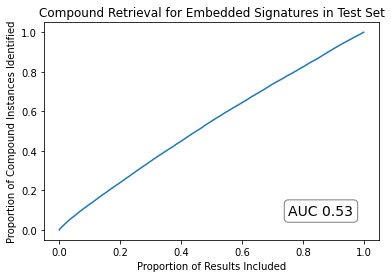

In [16]:
auc_lab = f"AUC {auc:.2f}"

fig, ax = plt.subplots()
ax.plot(quantile, recall)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.73, 0.1, auc_lab, transform=ax.transAxes, fontsize=14,
        verticalalignment='bottom', bbox=props)
plt.title("Compound Retrieval for Embedded Signatures in Test Set")
plt.xlabel("Proportion of Results Included")
plt.ylabel("Proportion of Compound Instances Identified")
plt.show()

In [17]:
#0.0005 lr, 2048 batch, 25 epochs, got loss 7.83 and 0.81 auc
#max_m 0.15